# Results from WandB


## Imports

In [1]:
import wandb
from community.utils.wandb_utils import get_wandb_artifact, get_wandb_runs
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd
import numpy.linalg as LA

ModuleNotFoundError: No module named 'community'

## Load Results

In [189]:
sweep_path = "gbena/funcspec/mjw4dzu9"
sweep_path = "m2snn/funcspec_V2/lf31u7wy"

sweep_id = sweep_path.split("/")[-1]

total_data = pd.read_pickle(f"../../results/sweep_tables/{sweep_id}")
total_data.columns, total_data.shape


(Index(['Step', 'best_acc', 'n_hidden', 'sparsity', 'task', 'bottleneck_det',
        'bottleneck_norm_1', 'bottleneck_norm_2', 'bottleneck_norm_fro',
        'bottleneck_norm_nuc', 'name'],
       dtype='object'),
 (166040, 11))

In [223]:
filtered_data = total_data[(total_data["Step"] == 2)]
tasks = ["all", "shared_goals"]

task_data = [filtered_data[(filtered_data["task"] == t)] for t in tasks]

In [224]:
task_values = {
    task: t[["n_hidden", "sparsity", "bottleneck_det"]].values.T
    for t, task in zip(task_data, tasks)
}
norms = ["1", "2", "fro", "nuc"]
norm_data = [
    {norm: t[f"bottleneck_norm_{norm}"].values for norm in norms} for t in task_data
]

normalized_values = {
    task: {norm: t[-1] / n for norm, n in n_data.items()}
    for (task, t), n_data in zip(task_values.items(), norm_data)
}

## Plot Smooth Heatmap

In [216]:
def gaussian_filter(x, y, sigmas):

    eps = 1e-10
    filter = np.exp(-((x / sigmas[0]) ** 2 + (y / sigmas[1]) ** 2))

    return filter


def filter_nans(values):
    idxs = np.isnan(values[-1])
    return [v[~idxs] for v in values]


def weighted_average(x, y, sigmas, values):

    x_values, y_values, z_values = values

    return (
        (z_values * gaussian_filter(x - x_values, y - y_values, sigmas))
    ).sum() / gaussian_filter(x - x_values, y - y_values, sigmas).sum()


def plot_filters(sigmas, values):
    x_values, y_values, z_values = values

    Y = np.linspace(y_values.min(), y_values.max(), 100)
    X = np.linspace(x_values.min(), x_values.max(), 100)

    points = [10, 50, 90]

    fig, axs = plt.subplots(1, len(points), figsize=(10, 5))
    for p, ax in zip(points, axs):

        point = [X[p], Y[p]]
        filter = lambda x, y: gaussian_filter(
            (x - point[0]), y - point[1], sigmas=sigmas
        ).sum()

        Z = np.array([[filter(x, y) for x in X] for y in Y])
        sns.heatmap(Z, ax=ax)


def movingaverage(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, "same")


def compute_and_plot(values, figax=None, log_scale=False, plot=False, random=True):

    x_values, y_values, z_values = filter_nans(values)

    if random:
        idxs = np.arange(len(x_values))
        np.random.shuffle(idxs)
        idxs = idxs[: len(idxs) // 10]
        values = x_values, y_values, z_values = (
            x_values[idxs],
            y_values[idxs],
            z_values[idxs],
        )

    smoothness = 3
    resolution = 300
    eps = 1e-4

    if not log_scale:
        X = np.linspace(x_values.min(), x_values.max(), resolution)
        Y = np.linspace(
            y_values.min(), y_values.max(), resolution
        )  # 500 x 500 takes 10s
    else:
        X = np.geomspace(np.maximum(x_values.min(), eps), x_values.max(), resolution)
        Y = np.geomspace(np.maximum(y_values.min(), eps), y_values.max(), resolution)
        # print(Y)
        # print(Y)

    Xm, Ym = np.meshgrid(X, Y)

    ratio = y_values / x_values
    ratio = movingaverage(ratio, len(ratio) // 3)
    sigmas = np.array([np.ones_like(ratio), ratio * 3]) * smoothness

    ratio = (y_values / x_values).mean()
    sigmas = np.array([1, 1.5 * ratio]) * smoothness

    vect_avg = np.vectorize(
        lambda x, y: weighted_average(x, y, sigmas, values), signature=("(),()->()")
    )
    Z = vect_avg(Xm, Ym)

    if plot:
        plot_filters(sigmas, values)

    if (figax) is None:

        plt.figure(figsize=(20, 10))
        plt.pcolormesh(X, Y, Z, cmap="viridis")
        if log_scale:

            """"""
            # plt.xscale("log")
            # plt.yscale("log")

        plt.ylim(y_values.min(), y_values.max())
        plt.xlim(x_values.min(), x_values.max())

        # plt.grid(True)
        plt.colorbar()
    else:
        fig, ax = figax
        pc = ax.pcolormesh(X, Y, Z, cmap="viridis")
        if log_scale:

            """"""
            # plt.xscale("log")
            # plt.yscale("log")

        ax.set_ylim(y_values.min(), y_values.max())
        ax.set_xlim(x_values.min(), x_values.max())

        fig.colorbar(pc, ax=ax)

    return (X, Y), (Xm, Ym), Z, sigmas

### heatmap

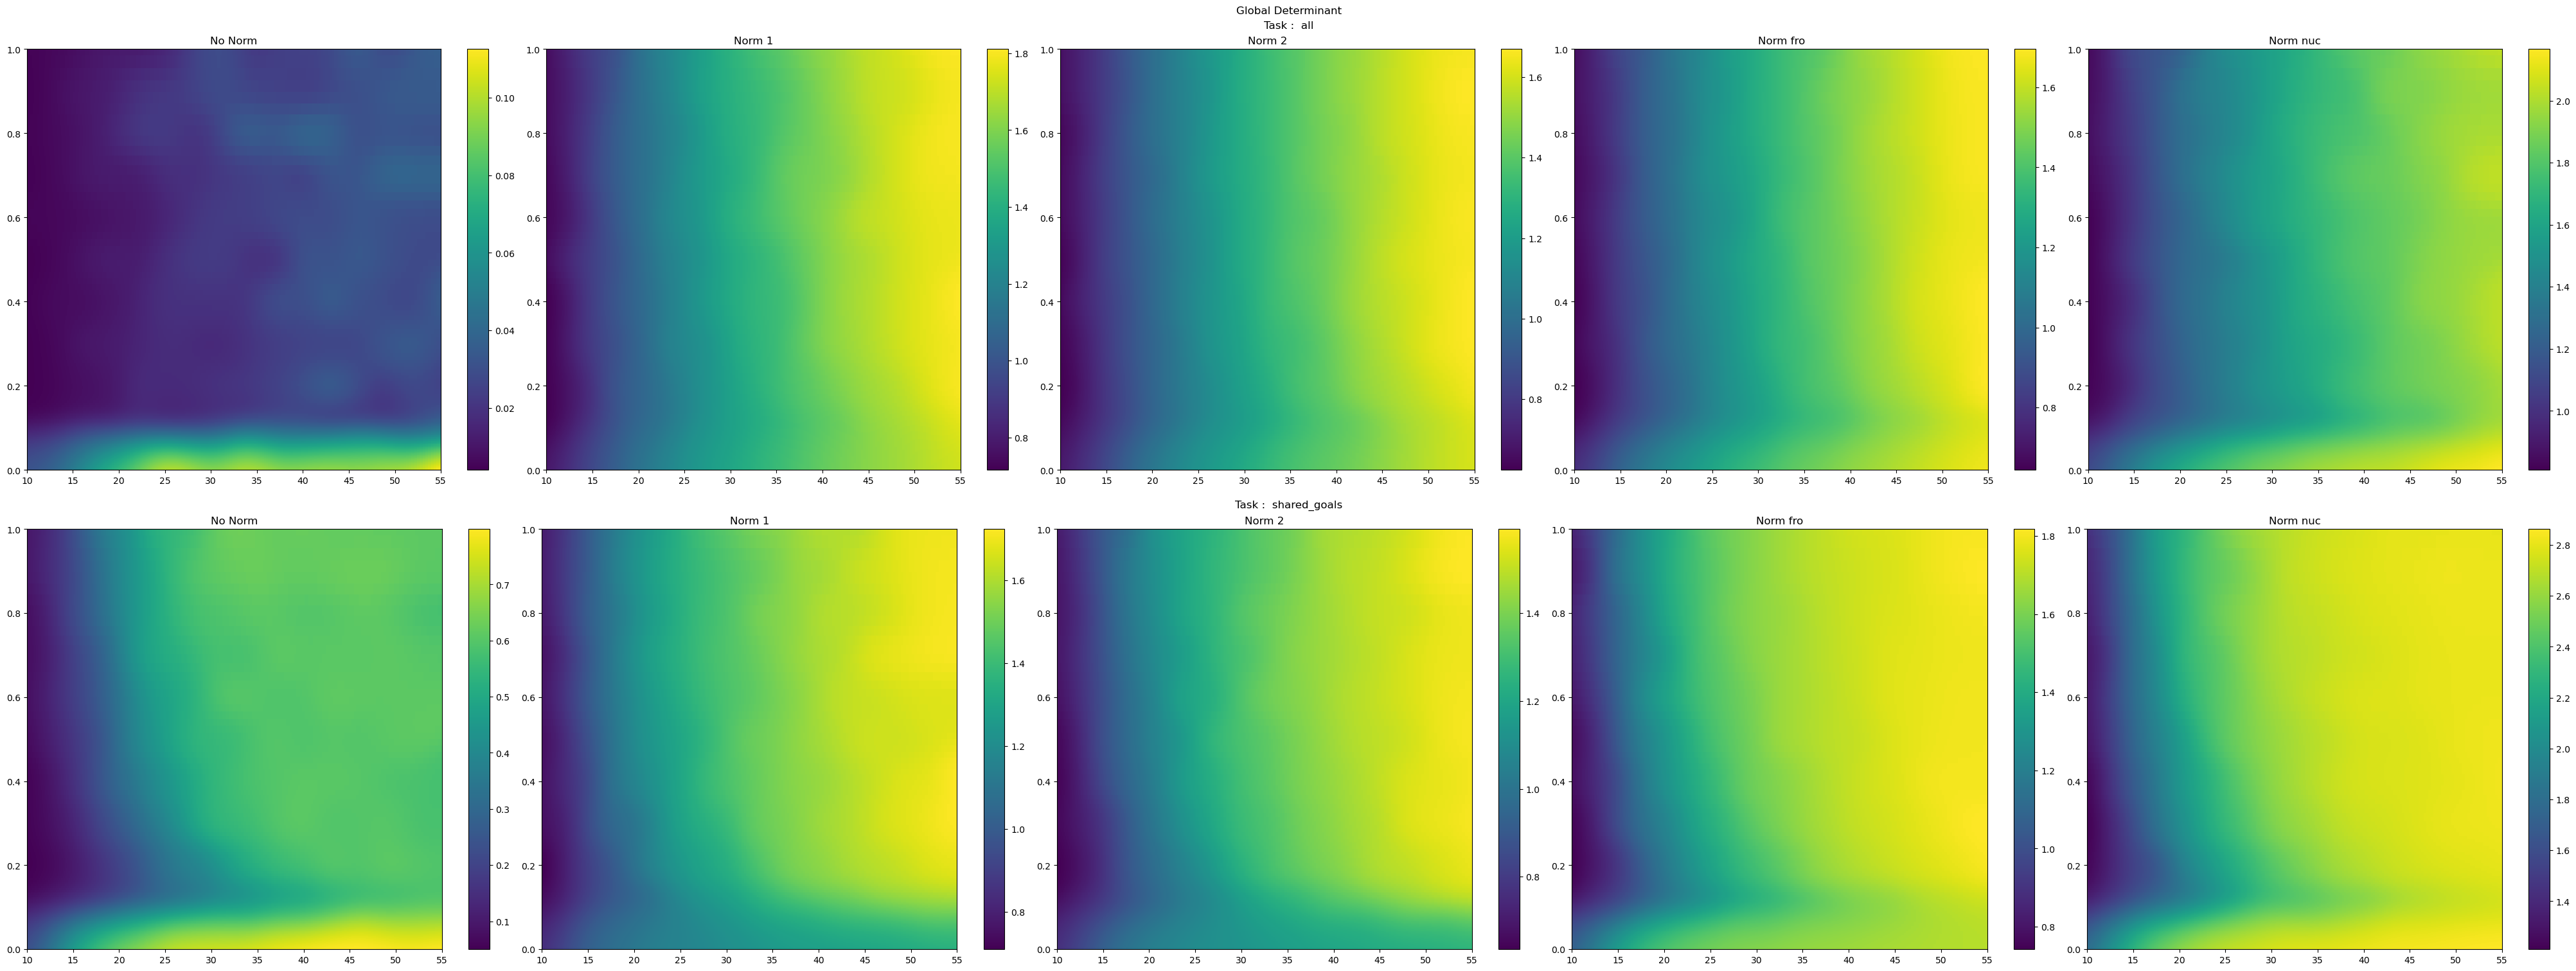

In [225]:
fig = plt.figure(constrained_layout=True, figsize=(40, 15))
fig.suptitle('Global Determinant')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)

for t, (subfig, task) in enumerate(zip(subfigs, tasks)) :

    subfig.suptitle(f'Task :  {task}')

    # create subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=len(norms) + 1)

    t_values = task_values[task].copy()
    norm_values = normalized_values[task]
    ax = axs[0]

    (X, Y), (X_mesh, Y_mesh), Z_diff, sigmas = compute_and_plot(
        t_values, (fig, ax), True, False, True
    )
    
    ax.set_title("No Norm")

    for (norm, n_values), ax in zip(norm_values.items(), axs[1:]):

        values = t_values.copy()
        values[-1] /= n_values

        (X, Y), (X_mesh, Y_mesh), Z_diff, sigmas = compute_and_plot(
            values, (fig, ax), True, False, True
        )

        ax.set_title(f"Norm {norm}")

# Scipy

In [226]:
from scipy.interpolate import griddata as gd


In [228]:
def get_colormesh(values, method="nearest", log_scale=True):

    x_values, y_values, z_values = values

    resolution = 500
    eps = 1e-4

    if not log_scale:
        X = np.linspace(x_values.min(), x_values.max(), resolution)
        Y = np.linspace(
            y_values.min(), y_values.max(), resolution
        )  # 500 x 500 takes 10s
    else:
        X = np.geomspace(np.maximum(x_values.min(), eps), x_values.max(), resolution)
        Y = np.geomspace(np.maximum(y_values.min(), eps), y_values.max(), resolution)
        # print(Y)

    X_mesh, Y_mesh = np.meshgrid(X, Y)

    Z = gd(
        (x_values, y_values), z_values, (X_mesh, Y_mesh), method=method, rescale=True
    )

    return X_mesh, Y_mesh, Z

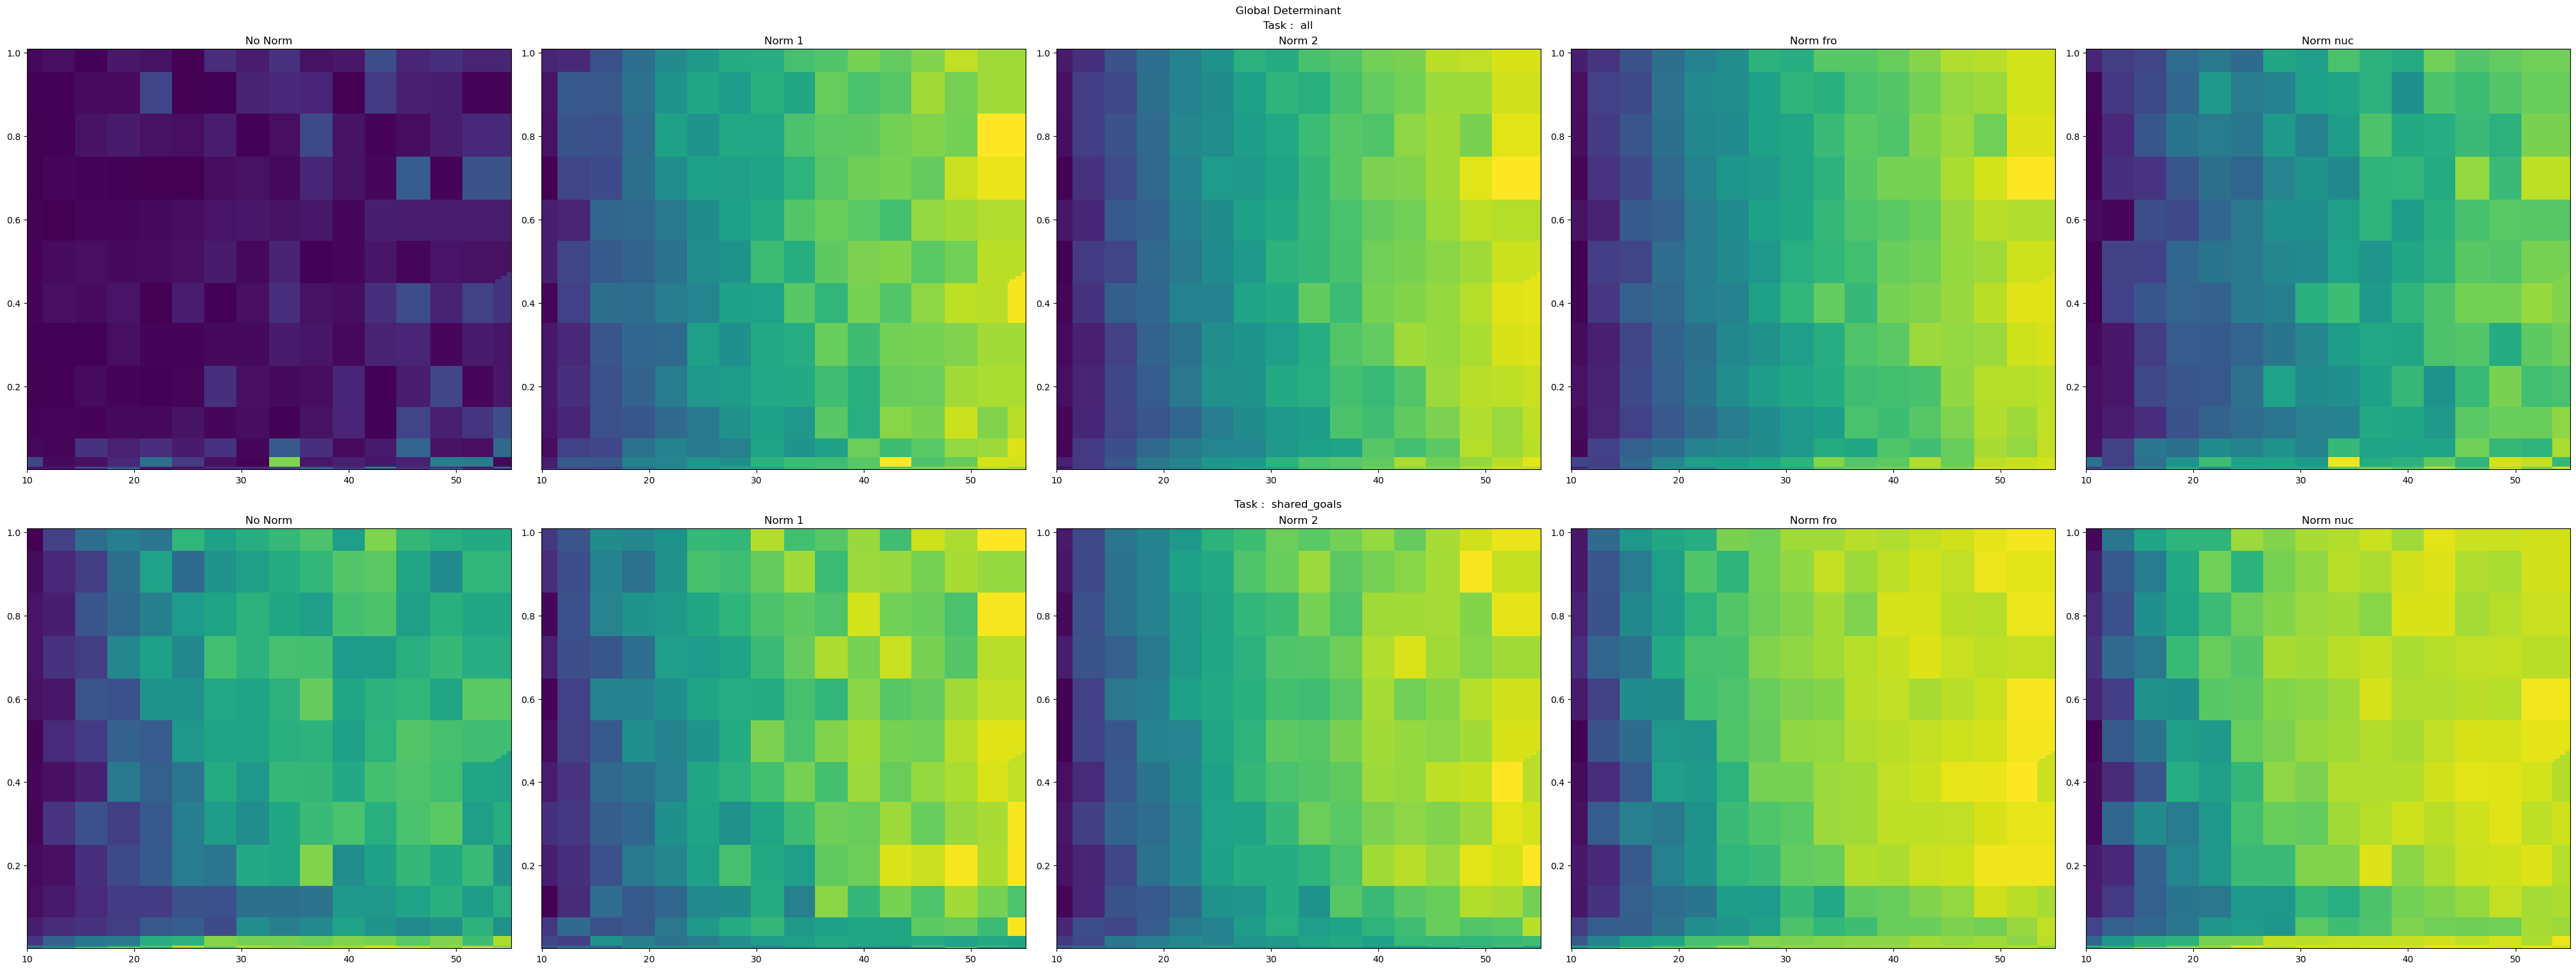

In [245]:
fig = plt.figure(constrained_layout=True, figsize=(40, 15))
fig.suptitle('Global Determinant')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)

method='linear'

for t, (subfig, task) in enumerate(zip(subfigs, tasks)) :

    subfig.suptitle(f'Task :  {task}')
    # create subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=len(norms) + 1)

    t_values = task_values[task].copy()
    norm_values = normalized_values[task]
    ax = axs[0]

    X_mesh, Y_mesh, Z = get_colormesh(t_values)
    ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")
    
    ax.set_title("No Norm")


    for (norm, n_values), ax in zip(norm_values.items(), axs[1:]):

        values = t_values.copy()
        values[-1] /= n_values

        X_mesh, Y_mesh, Z = get_colormesh(values)
        ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

        ax.set_title(f"Norm {norm}")


In [232]:
values.shape

(3, 41540)

In [242]:
normalized_values['all']['1'].shape

(41540,)

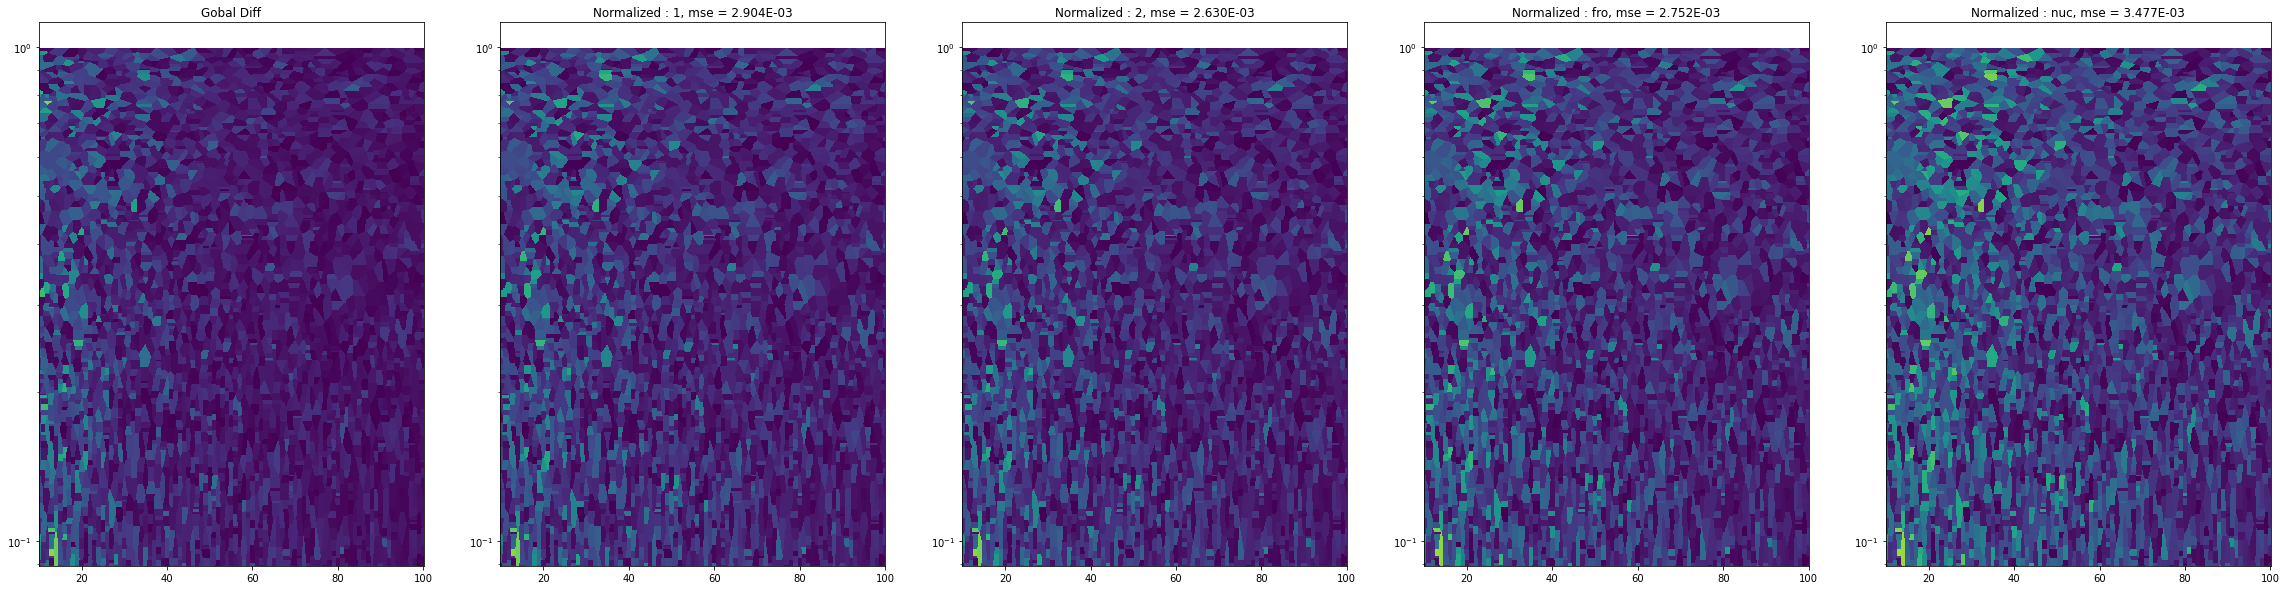

In [27]:
fig, axs = plt.subplots(1, len(norms) + 1, figsize=(40, 10))

Zs = []

ax = axs[0]

X_mesh, Y_mesh, Z = plot_colormesh(task_values[1])
ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

Zs.append(Z)

if log_scale:

    # plt.xscale("log")
    ax.set_yscale("log")

# plt.ylim(y_values.min(), y_values.max())
# plt.xlim(x_values.min(), x_values.max())

# plt.grid(True)
ax.set_title(f"Gobal Det")

for i, (ax, norm) in enumerate(zip(axs[1:], norms.items())):

    values = task_values[1]
    Z = gd(
        (x_values, y_values),
        z_values_det / norm[1],
        (X_mesh, Y_mesh),
        method="nearest",
        rescale=True,
    )
    ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

    # plt.imshow(Z)
    if log_scale:

        # plt.xscale("log")
        ax.set_yscale("log")

    # plt.ylim(y_values.min(), y_values.max())
    # plt.xlim(x_values.min(), x_values.max())

    # plt.grid(True)
    ax.set_title(f"Normalized : {norm[0]}, mse = {((Zs[0] - Z) ** 2).mean() :.3E}")
    Zs.append(Z)

fig.show()

In [21]:
Zs[0]


array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.12865786, 0.13249865, 0.13633943, ..., 0.02906523, 0.02685999,
        0.02465476],
       [0.41673348, 0.35764096, 0.29854844, ..., 0.04601754, 0.04871633,
        0.05141512],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [18]:
mse = lambda x, y: ((x - y) ** 2).mean()

Z_mses = np.array([[mse(Z1, Z2) for Z1 in Zs] for Z2 in Zs])

In [19]:
Z_mses


array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

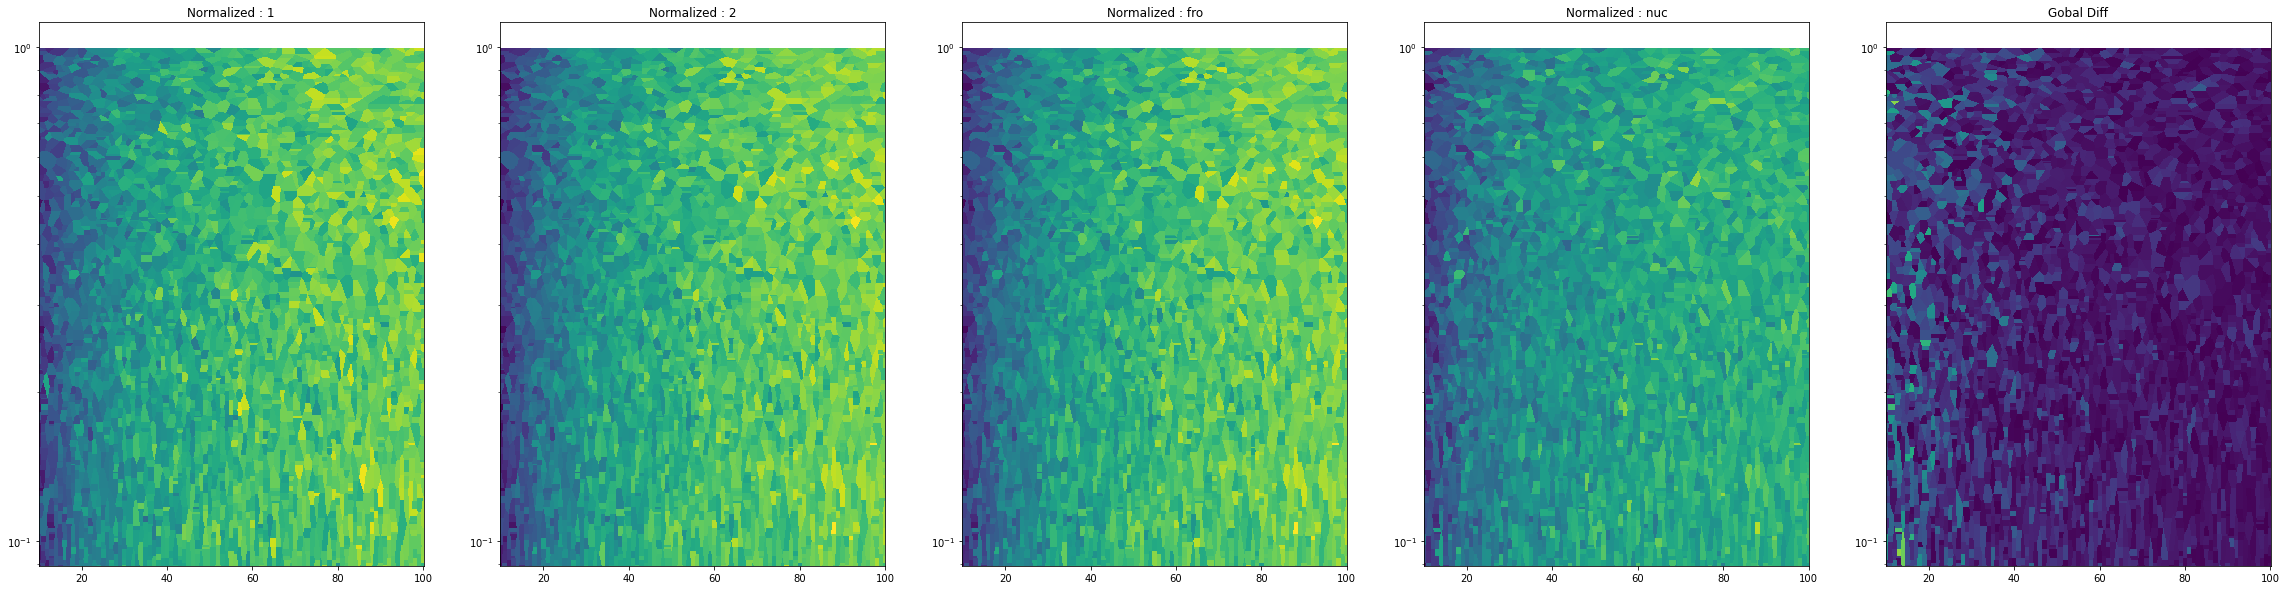

In [13]:
fig, axs = plt.subplots(1, len(norms) + 1, figsize=(40, 10))

Zs = []

for i, (ax, norm) in enumerate(zip(axs, norms.items())):

    Z = gd(
        (x_values, y_values), norm[1], (X_mesh, Y_mesh), method="nearest", rescale=True
    )
    ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

    # plt.imshow(Z)
    if log_scale:

        # plt.xscale("log")
        ax.set_yscale("log")

    # plt.ylim(y_values.min(), y_values.max())
    # plt.xlim(x_values.min(), x_values.max())

    # plt.grid(True)
    ax.set_title(f"Normalized : {norm[0]}")
    Zs.append(Z)

ax = axs[-1]

Z = gd(
    (x_values, y_values),
    z_values_diff,
    (X_mesh, Y_mesh),
    method="nearest",
    rescale=True,
)
ax.pcolormesh(X_mesh, Y_mesh, Z, cmap="viridis")

if log_scale:

    # plt.xscale("log")
    ax.set_yscale("log")

# plt.ylim(y_values.min(), y_values.max())
# plt.xlim(x_values.min(), x_values.max())

# plt.grid(True)
ax.set_title(f"Gobal Diff")
Zs.append(Z)

fig.show()

# Find new metric

In [2]:
import numpy as np
import numpy.linalg as LA
from numpy.linalg import LinAlgError

In [8]:
def agent_diff(col) : 
    return (col[1] - col[0])/col.sum()

def global_diff(M) : 
    return np.abs(agent_diff(M[:, 0]) - agent_diff(M[:, 1] )) / 2

def new_metric(M) : 
    return  np.abs(LA.det(M)) / M.sum(0).prod()

In [29]:
n_agents = 2

M = np.random.rand(n_agents, n_agents)

M = np.eye(n_agents)
M[0, 1] = 1

new_metric(M), np.abs(LA.det(M))

(0.5, 1.0)

In [17]:
M = np.arange(n_agents ** 2).reshape(n_agents, n_agents)
M

array([[0, 1],
       [2, 3]])

In [26]:
np.concatenate((np.arange(10, 31, 3), np.arange(31, 102, 7)))

array([ 10,  13,  16,  19,  22,  25,  28,  31,  38,  45,  52,  59,  66,
        73,  80,  87,  94, 101])

In [128]:
idxs = [0, 2]
sub_mat = lambda M, idx : np.delete(np.delete(M, idx[0], 0), idx[1], 1).squeeze()
sub_mat(M, idxs), M

(array([[0., 1.],
        [0., 0.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [180]:
def reccursive_new_metric(M) : 
    if M.shape[0] > 2 : 
            
        res = new_metric(M)

        for i in range(M.shape[0]) : 
            for j in range(M.shape[1]) : 
                subM = sub_mat(M, [i, j])
                res += reccursive_new_metric(subM)


    else : 
        res = new_metric(M)

    print(res)
    return res


   

In [194]:
M = np.array([[0, 0.5, 1.], [0, 1, 1.], [0., 1., 1]]) 
eps = 1e-10
M += np.ones_like(M) * eps 


new_metric(M), reccursive_new_metric(M) / 

0.0
0.0
0.0
0.16666666664444443
0.0
0.16666666664444466
0.16666666664444443
0.0
0.16666666664444466
0.6666666665777782
1.0
nan
nan
nan
1.0
nan
nan
nan
1.0
nan


/tmp/ipykernel_99901/1730411033.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return  np.abs(LA.det(M)) / M.sum(0).prod()


(0.0, nan)

In [184]:
new_metric(sub_mat(M, (2, 1)))

0.4999999998999998

In [169]:
sub_mat(M, (0, 1)).sum(0).prod()

0.0

In [176]:
new_metric(sub_mat(M, (0, 1)))

/tmp/ipykernel_99901/1730411033.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return  np.abs(LA.det(M)) / M.sum(0).prod()


nan

In [172]:
LA.det([[0, 0], [0, 1]])

0.0